In [1]:
from dataclasses import dataclass

import networkx as nx 
import torch
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import to_networkx

from custom_modules import DataGenerator, PersonnelScheduleEnv, RLagent, ActorMemoryWrapper, Actor

2024-08-29 06:11:46.574779: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 06:11:48.267061: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 06:11:48.267308: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 06:11:48.331059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 06:11:49.440993: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 06:11:49.451969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
@dataclass
class EvaluationConfig:
    output_dir = "RL_PersSched" 
    max_steps = 20
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_dim = 3
    num_message_passing = 4

config = EvaluationConfig()

In [3]:
gnn = RGCNConv(in_channels = (config.hidden_dim, config.hidden_dim), out_channels=config.hidden_dim, num_relations=1).to(config.device)
dim_employee = 1
projection_employees = torch.nn.Linear(dim_employee, config.hidden_dim).to(config.device)
dim_shift = 7
projection_shifts = torch.nn.Linear(dim_shift, config.hidden_dim).to(config.device)

gnn.load_state_dict(torch.load(config.output_dir + "/gnn_weights", map_location=config.device))
projection_employees.load_state_dict(torch.load(config.output_dir + "/projection_employees_weights", map_location=config.device))
projection_shifts.load_state_dict(torch.load(config.output_dir + "/projection_shifts_weights", map_location=config.device))

/tmp/ipykernel_51155/789500737.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gnn_employees.load_state_dict(torch.load(config.output_dir + "/gnn_employees_weights", map

<All keys matched successfully>

In [23]:
env = PersonnelScheduleEnv(employees=DataGenerator.get_random_employees(2,2), shifts=DataGenerator.get_week_shifts(), assignments=DataGenerator.get_empty_assignments(), device=config.device)
agent = RLagent(gnn, projection_employees, projection_shifts, config.num_message_passing) 
actor = Actor(agent, env=env, max_steps=config.max_steps)

In [24]:
steps = actor.execute_episode()

In [25]:
print("Is terminated: ", env.terminated())
print("Planning: ")
env.get_current_planning()

Is terminated:  False
Planning: 


{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [0],
 10: [],
 11: [0],
 12: [],
 13: []}

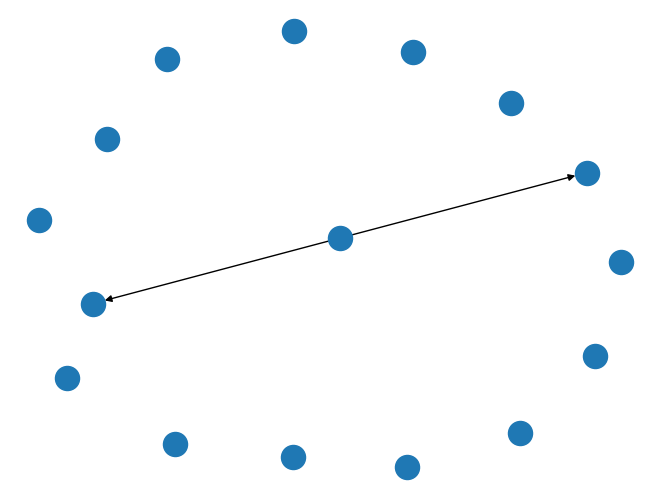

In [26]:
g=to_networkx(env.state)
nx.draw(g)